In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import boost_histogram as bh

from scipy import stats
from scipy.optimize import curve_fit

from lmfit.models import *
from pyarrow import csv

import warnings
warnings.filterwarnings('ignore')

MP = 0.93827208816
# E0 = 4.81726
ME = 0.00051099895

In [2]:
#df = pd.read_csv("/Users/tylern/Data/momCorr.csv")
file_name = "/Users/tylern/Data/momCorr.csv"

pyTable = csv.read_csv(
        file_name,
        read_options=csv.ReadOptions(use_threads=True)
    )
all_data = pyTable.to_pandas(strings_to_categorical=True)
channel = all_data[all_data.type == "channel"].copy()

df = all_data[all_data.type == "elastic"].copy()

df = df.drop(['type'], axis=1)
df = df[(df.W_uncorr > 0.5) & (df.W_uncorr < 1.5)]

df.dropna(inplace=True)


df.head()

,e_p,e_theta,e_phi,p_p,p_theta,p_phi,W_uncorr,Q2_uncorr,sector
21,3.448219,0.388294,2.560314,2.054274,0.695117,-0.577250,0.988055,2.473166,6
69,3.891342,0.297288,-0.594945,1.562376,0.829981,2.556784,0.986564,1.644572,3
87,3.522692,0.378654,-1.620164,1.984342,0.706325,1.515471,0.951580,2.404163,4
116,3.823266,0.317088,-1.668201,1.657202,0.796034,1.473546,0.953568,1.836335,4
143,3.659125,0.349334,1.656778,1.820539,0.746598,-1.485054,0.961428,2.129302,1


In [59]:
@np.vectorize
def E_beam_calc(theta_e, theta_p):
    a = np.tan(theta_e/2.0)*np.tan(theta_p)
    b = (1/a) - 1
    return MP * b

@np.vectorize
def E_prime_elastic(E0, theta_e):
    a = (2*E0)/MP
    a *= np.sin(theta_e/2.0)**2
    a += 1
    return (E0/a)

def Bt(theta_e):
    """
    Mom Corrections for e6 (CLAS-NOTE 2003-005) 
    """
    Itor = 3376.8
    rad = (180/np.pi)
    a = 0.76 * Itor
    b = 3375 * (theta_e/rad)
    c = a/b
    if theta_e >= np.pi/8:
        return c
    else:
        return c*np.sin(4*theta_e)**2
    

def Dtheta(phi_e, theta_e, A, B, C, D):
    """
    Mom Corrections for e6 (CLAS-NOTE 2003-005) 
    """
    first = (A+B*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (C+D*phi_e)*np.sin(theta_e)
    return first + second

def Dpp(phi_e, theta_e, p, E, F, G, H):
    """
    Mom Corrections for e6 (CLAS-NOTE 2003-005) 
    """
    first = (E+F*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (G+H*phi_e)*np.sin(theta_e)
    
    return (first + second)*(p/Bt(theta_e))
    
def f(theta_e, phi_e, J, K, L, M, N, O):
    f = (J * np.cos(theta_e) + K * np.sin(theta_e) + L * np.sin(2*theta_e))
    f += (M * np.cos(theta_e) + N * np.sin(theta_e) + O * np.sin(2*theta_e))*phi_e
    return f
    

In [4]:
df['e_beam'] = E_beam_calc(df.e_theta, df.p_theta)

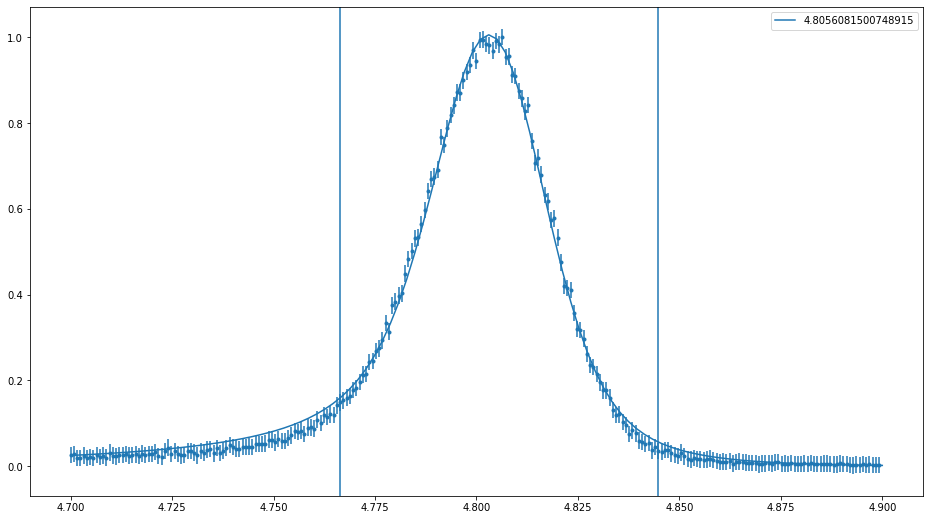

<Parameter 'sigma', value=0.00979702622900458 +/- 4.81e-05, bounds=[0.0:inf]>


In [47]:
fig = plt.figure(figsize=(16,9))

e_beam = df.loc[:,'e_beam'].to_numpy()
y, x = bh.numpy.histogram(e_beam, range=(4.7, 4.9), bins=250)
y = y/np.max(y)
x = x[:-1]
xs = np.linspace(4.7, 4.9, 100)

ebar = plt.errorbar(x, y, yerr=stats.sem(y), fmt='.')

mod = SkewedVoigtModel()
pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)
plt.plot(xs, out.eval(x=xs), 'r-', c=ebar[0].get_color(), label=out.params['center'].value)
top = out.params['center']+4*out.params['sigma']
bot = out.params['center']-4*out.params['sigma']
plt.axvline(top)
plt.axvline(bot)

plt.legend()
plt.show()

E0 = out.params['center'].value
df = df[(df.e_beam >= bot) & (df.e_beam <= top)]

In [29]:
%%cython 
#--annotate
import numpy as np
cimport numpy as np
from libc.math cimport sin, cos, sqrt
cimport cython

cdef float MP = 0.93827208816
cdef float ME = 0.00051099895

cdef float p_targ_px = 0.0
cdef float p_targ_py = 0.0
cdef float p_targ_pz = 0.0
cdef float p_targ_E = MP


@np.vectorize
def calc_W(float E0, float e_p, float e_theta, float e_phi):
    cdef float e_beam_px = 0.0
    cdef float e_beam_py = 0.0
    cdef float e_beam_pz = sqrt(E0**2-ME**2)
    cdef float e_beam_E = E0

    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px + p_targ_px
    cdef float temp_py = e_beam_py - e_prime_py + p_targ_py
    cdef float temp_pz = e_beam_pz - e_prime_pz + p_targ_pz
    cdef float temp_E = e_beam_E - e_prime_E + p_targ_E
    
    
    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2
    cdef float temp3 = sqrt(-temp2)
    
    
    return temp3


@np.vectorize
def calc_q2(float E0, float e_p, float e_theta, float e_phi):
    cdef float e_beam_px = 0.0
    cdef float e_beam_py = 0.0
    cdef float e_beam_pz = sqrt(E0**2-ME**2)
    cdef float e_beam_E = E0
    
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px
    cdef float temp_py = e_beam_py - e_prime_py
    cdef float temp_pz = e_beam_pz - e_prime_pz
    cdef float temp_E = e_beam_E - e_prime_E

    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2

    return temp2

In [62]:
%time df['w_corr'] = calc_W(E0, df.e_p, df.e_theta, df.e_phi)
%time df['q2_corr'] = calc_q2(E0, df.e_p, df.e_theta, df.e_phi)

%time all_data['w_corr'] = calc_W(E0, all_data.e_p, all_data.e_theta, all_data.e_phi)
%time all_data['q2_corr'] = calc_q2(E0, all_data.e_p, all_data.e_theta, all_data.e_phi)


df['w_corr'] = calc_W(df.e_beam, df.e_p, df.e_theta, df.e_phi)

print(E0)

CPU times: user 34.7 ms, sys: 6.07 ms, total: 40.8 ms
Wall time: 39.2 ms
CPU times: user 30.7 ms, sys: 2.96 ms, total: 33.7 ms
Wall time: 33.6 ms
CPU times: user 921 ms, sys: 238 ms, total: 1.16 s
Wall time: 1.16 s
CPU times: user 892 ms, sys: 209 ms, total: 1.1 s
Wall time: 1.1 s
4.8056081500748915


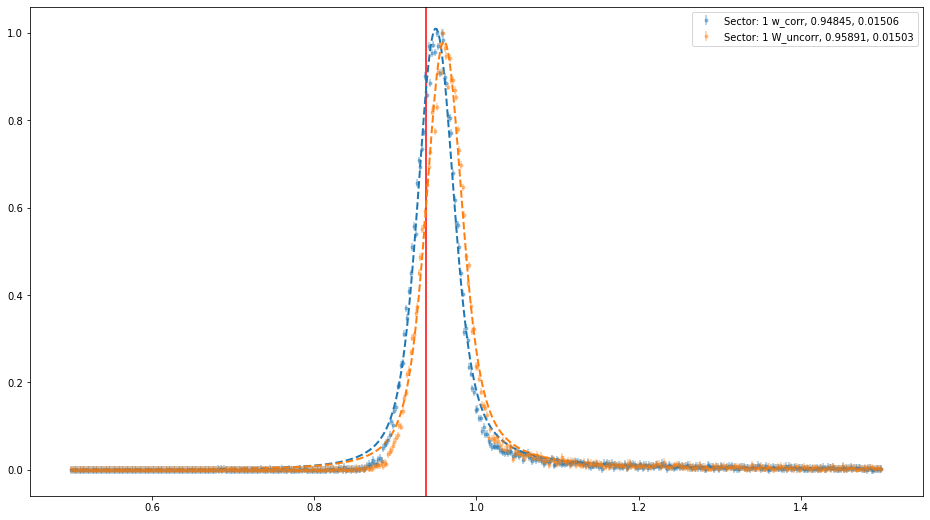

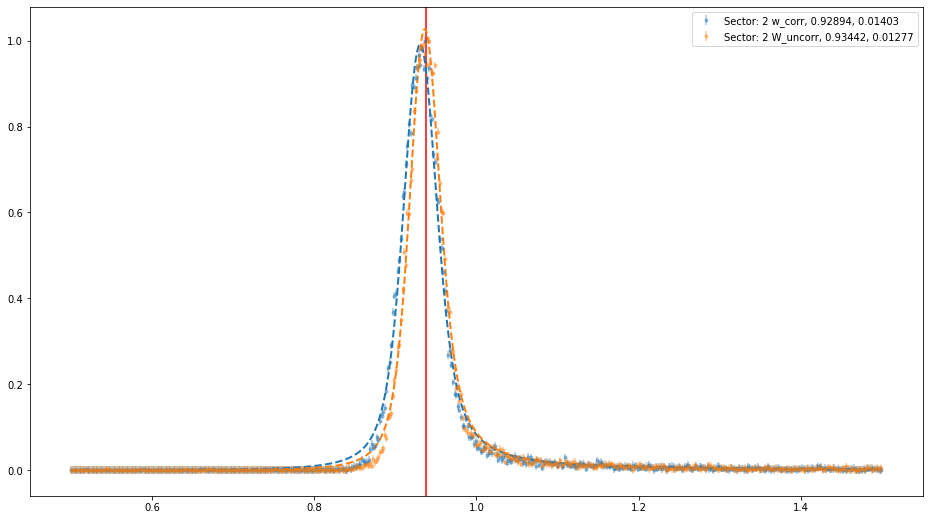

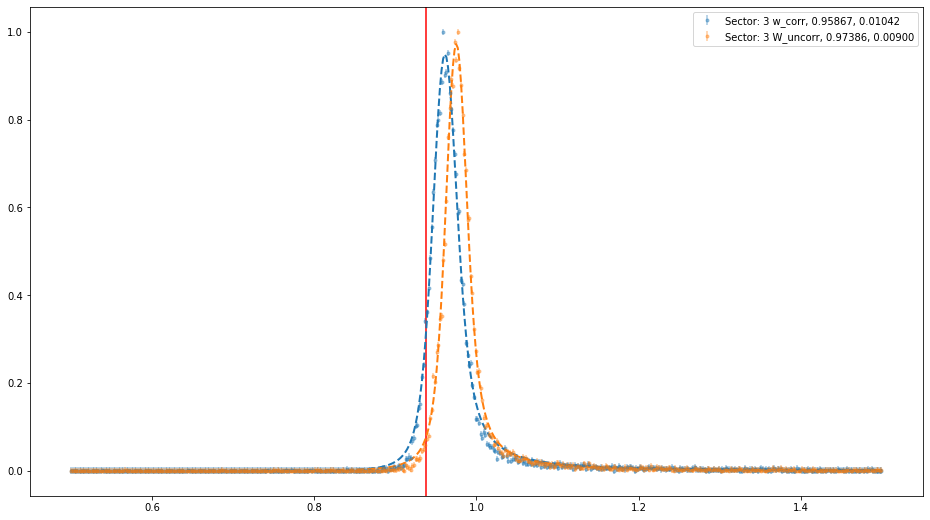

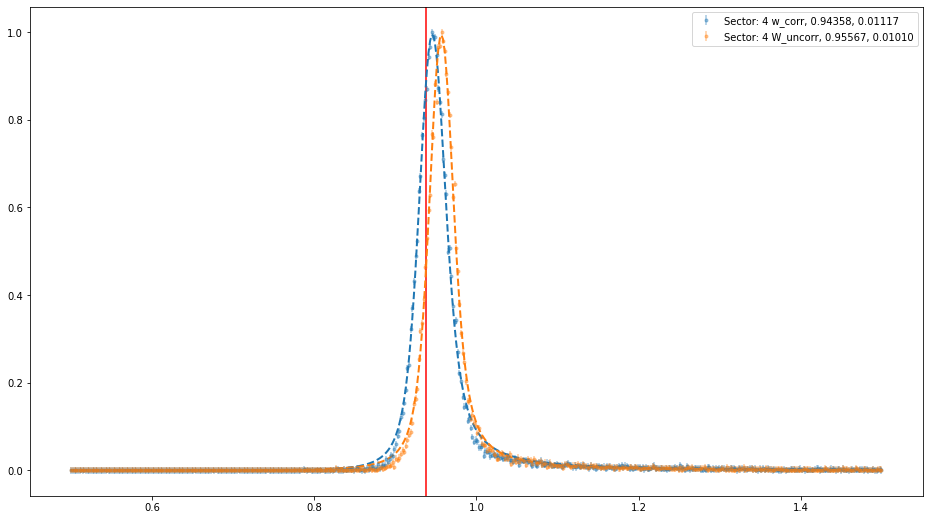

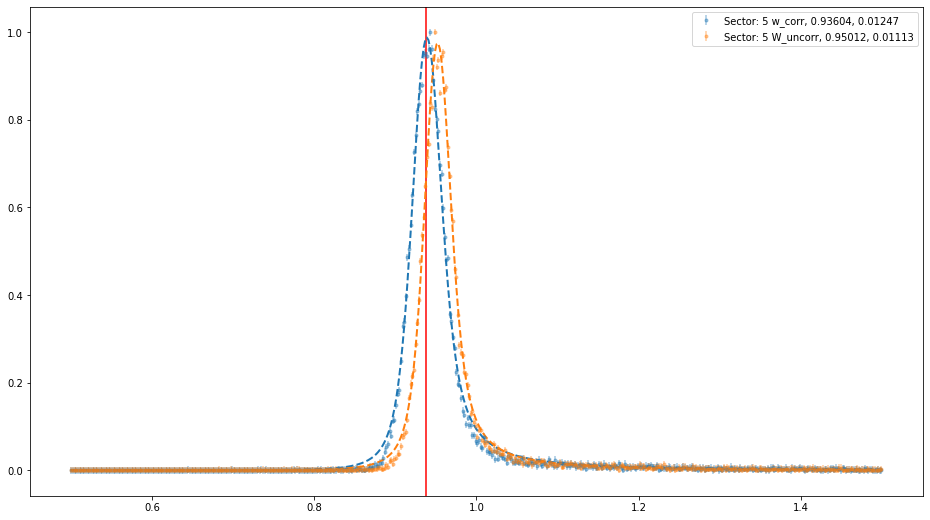

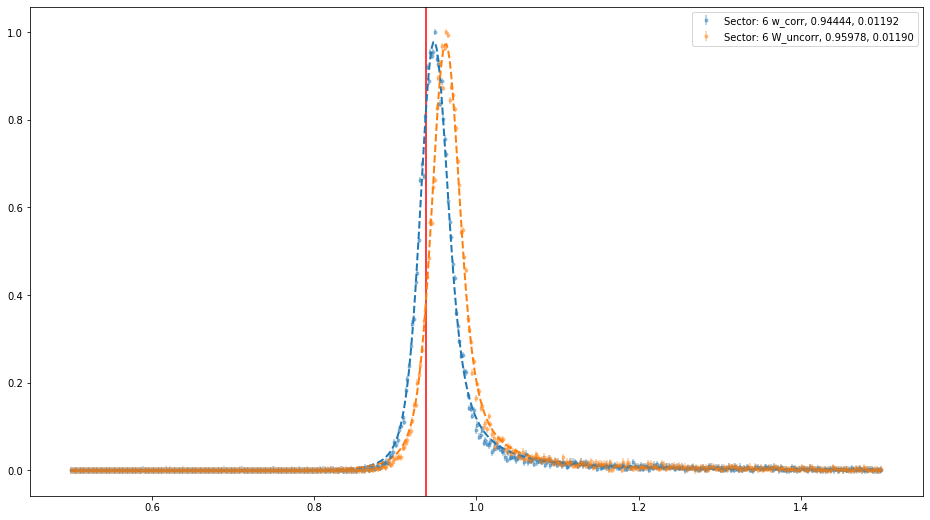

In [61]:
for sec in range(1,7):
    fig = plt.figure(figsize=(16,9))
    plt.axvline(MP, c='r')
    xs=np.linspace(0.5, 1.5, 500)
    data = df[df.sector == sec].dropna()
    for W in ['w_corr', 'W_uncorr']:
        y, x = np.histogram(data[W], bins=500, range=(0.5,1.5))
        y = y/np.max(y)
        x = (x[:-1]+x[1:])/2.0
        
        mod = SkewedVoigtModel()
        pars = mod.guess(y, x=x)
        out = mod.fit(y, pars, x=x, nan_policy='omit')        
        ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, 
                            label=f'Sector: {sec} {W}, {out.params["center"].value:0.5f}, {out.params["sigma"].value:0.5f}')
        plt.plot(xs, out.eval(x=xs), '--', c=ebar[0].get_color(), lw=2)
        
    plt.legend()
    plt.show()

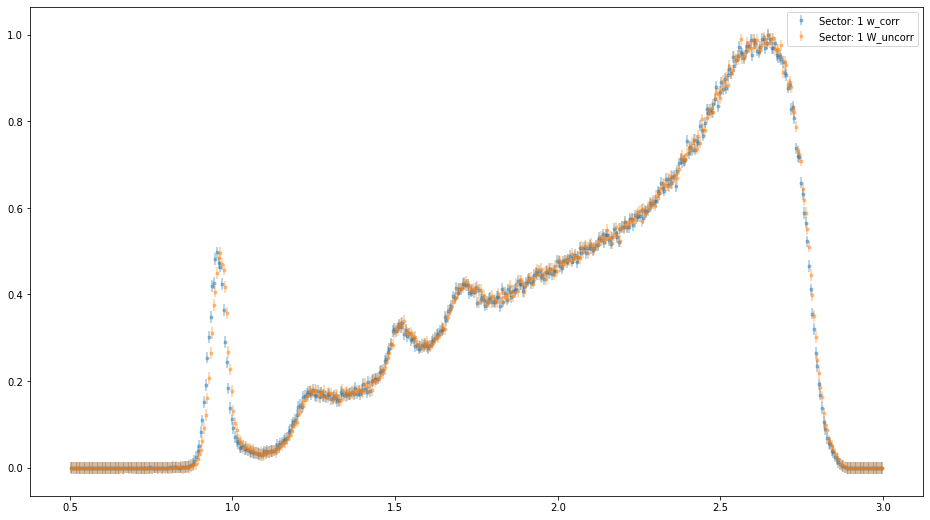

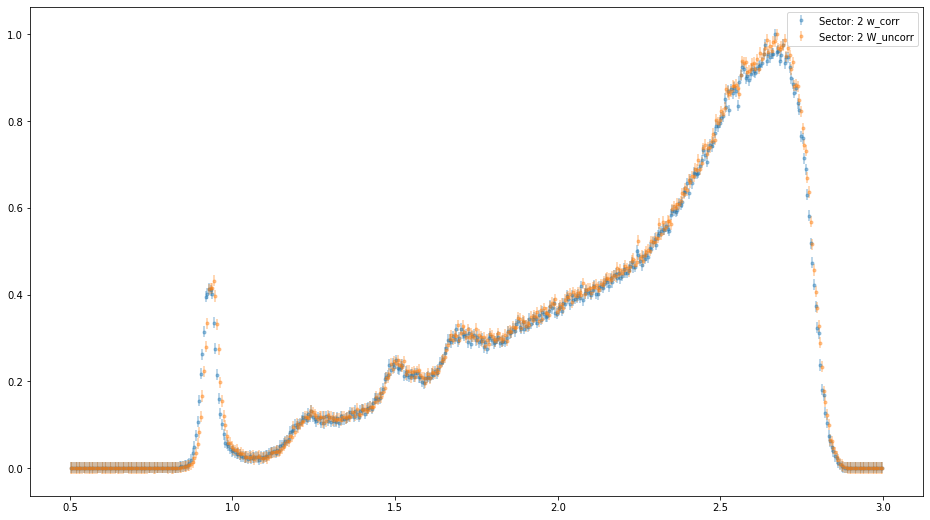

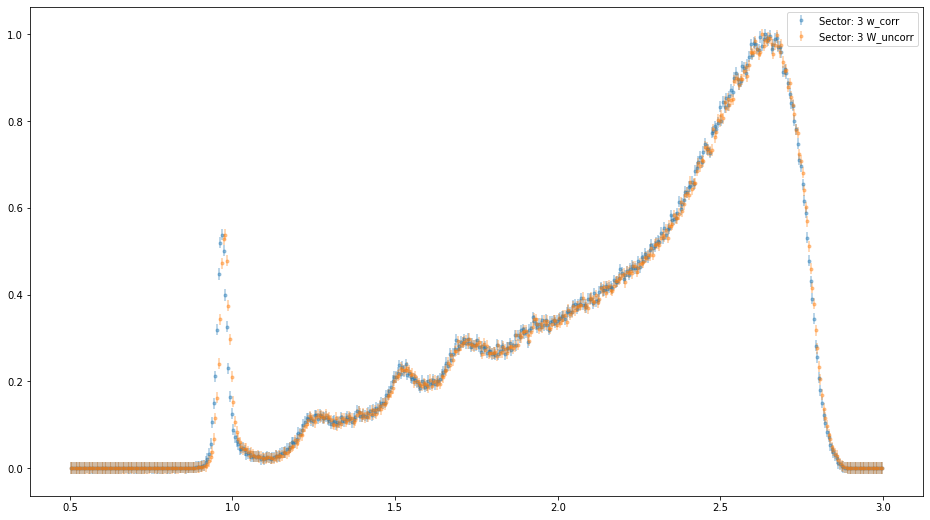

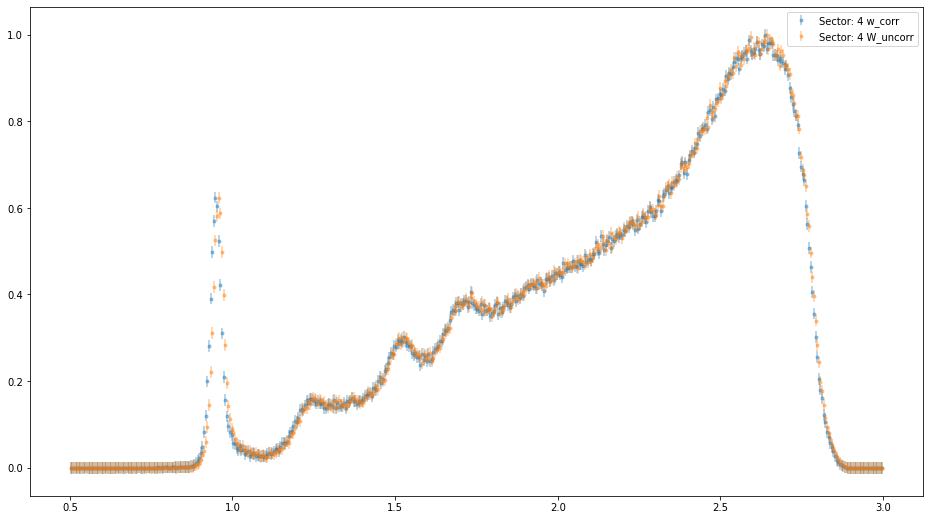

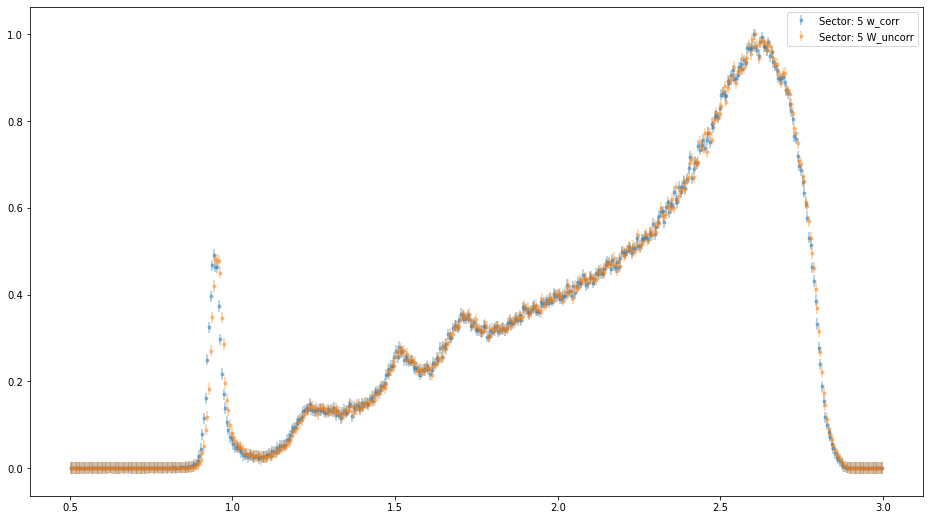

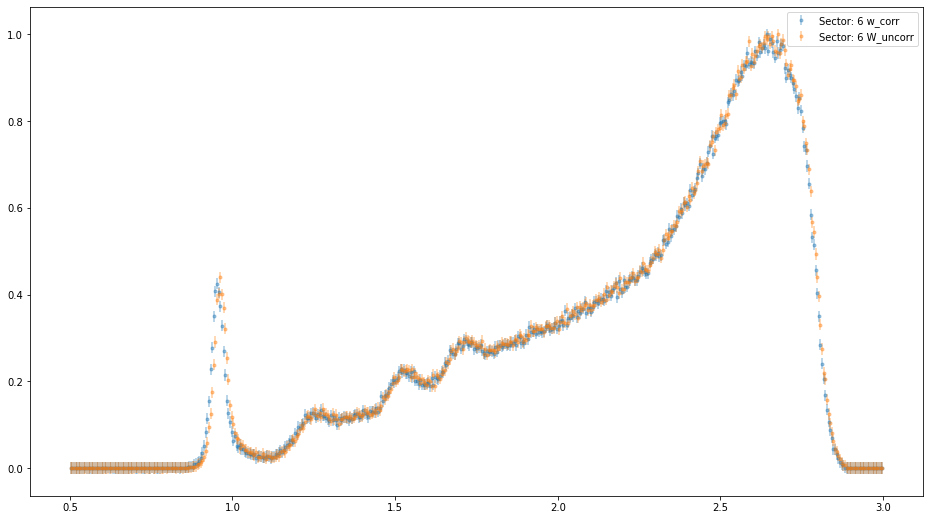

In [50]:
for sec in range(1, 7):
    fig = plt.figure(figsize=(16,9))
    xs=np.linspace(0.5, 4.5, 500)
    for W in ['w_corr', 'W_uncorr']:
        y, x= np.histogram(all_data[all_data.sector == sec][W], bins=500, range=(0.5,3.0))
        y = y/np.max(y)
        x = (x[:-1]+x[1:])/2.0
        
        ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, 
                            label=f'Sector: {sec} {W}')


    plt.legend()
    plt.show()

In [53]:
df['elastic_energy'] = E_prime_elastic(E0,df.e_theta)

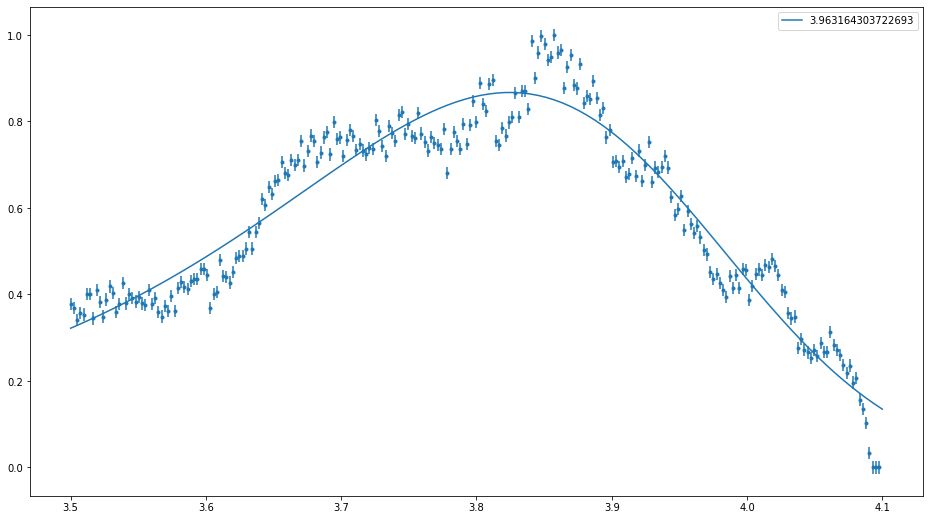

In [58]:
fig = plt.figure(figsize=(16,9))

elastic_energy = df.loc[:,'elastic_energy'].to_numpy()
y, x = bh.numpy.histogram(elastic_energy, range=(3.5, 4.1), bins=250)
y = y/np.max(y)
x = x[:-1]
xs = np.linspace(3.5, 4.1, 100)

ebar = plt.errorbar(x, y, yerr=stats.sem(y), fmt='.')

mod = SkewedVoigtModel()
pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)
plt.plot(xs, out.eval(x=xs), 'r-', c=ebar[0].get_color(), label=out.params['center'].value)


plt.legend()
plt.show()